similarly to volatility clustering, intermittent time series is a problem usually (but not exclusively) encountered in business applications. When predicting sales or demand in retail, we have three main issues to deal with: data is (frequently) integer-valued, intermittent and not that large. We will discuss those different aspects in the following sections:

* [Croston model](#section-one)
* [ML approach](#section-two)
* [New launches](#section-three)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import warnings
from data_sources import *

In [2]:
# general settings
class CFG:
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})
warnings.simplefilter(action='ignore', category= FutureWarning)

In [3]:
def my_rmse(x,y):
    """

    :param x:
    :param y:
    :return:
    """
    return np.round(np.sqrt(mse(x, y)), 4)

We will be using the data from the M5 competition: https://www.kaggle.com/c/m5-forecasting-accuracy. The contest used a hierarchical sales data from Walmart to forecast daily sales for the next 28 days. From the comp description page: "*The data covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events*". 


We start by formatting the data to a more usable format.

In [4]:
xdat = pd.read_csv(sales_train_validation)
xdat = xdat.loc[xdat.state_id == 'CA']
xdat.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [5]:
def reduce_mem_usage(df):
    """
    iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

xdat = reduce_mem_usage(xdat)  # tqdm progress bars

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


In [6]:
# melt the data into long format
xdat = pd.melt(xdat, id_vars=[
    'id',
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id'
], var_name='d', value_name='sales').dropna()

# get proper timestamps
xcal = pd.read_csv(calendar)

In [7]:
xdat = pd.merge(
    xdat,
    xcal,
    on='d',
    how='left'
)

del xcal

In [8]:
xdat.drop([
    'd',
    'wm_yr_wk',
    'weekday',
    'month',
    'year',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_TX',
    'snap_WI',
    'state_id'
], axis=1, inplace = True)

xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


That looks more manageable - let's get started.


<a id="section-one"></a>
# Croston model

## Basic Croston

A first simple approach to predicting intermittent demand series is the Croston model, which takes a three step approach:
- evaluate the average demand level when there is a demand occurrence
- evaluate the average time between two demand occurrences
- forecast the demand as the demand level (when there is an occurrence) multiplied by the probability of having an occurrence.

We go about this by adjusting exponential smoothing to our problem. If we denote the actual demand level by $X_t$ and our level estimate as $a_t$, then if $X_t > 0$ we get:

\begin{equation}
a_{t+1} = \alpha X_t + (1- \alpha) a_t 
\end{equation}

and $a_{t+1} = a_t$ otherwise; $\alpha$ has the same role as in the basic exponential smoothing (see https://www.kaggle.com/konradb/ts-1a-smoothing-methods for a refresher). 

A second important component of a model for an intermittent time series is periodicity: we capture time between two demand occurrences $p$ and time elapsed time elapsed since the previous demand occurrence $q$. As before, for $X_t > 0$ we can specify

\begin{equation}
p_{t+1} = \alpha q + (1-\alpha) p_t
\end{equation}

and $p_{t+1} = p_t$ otherwise. The forecast for a given period is the given by

\begin{equation}
f_{t+1} = \frac{a_t}{p_t}
\end{equation}


How does it perform in practice? Let's begin by subsetting our dataset to a single product x store combination:

<AxesSubplot:xlabel='date'>

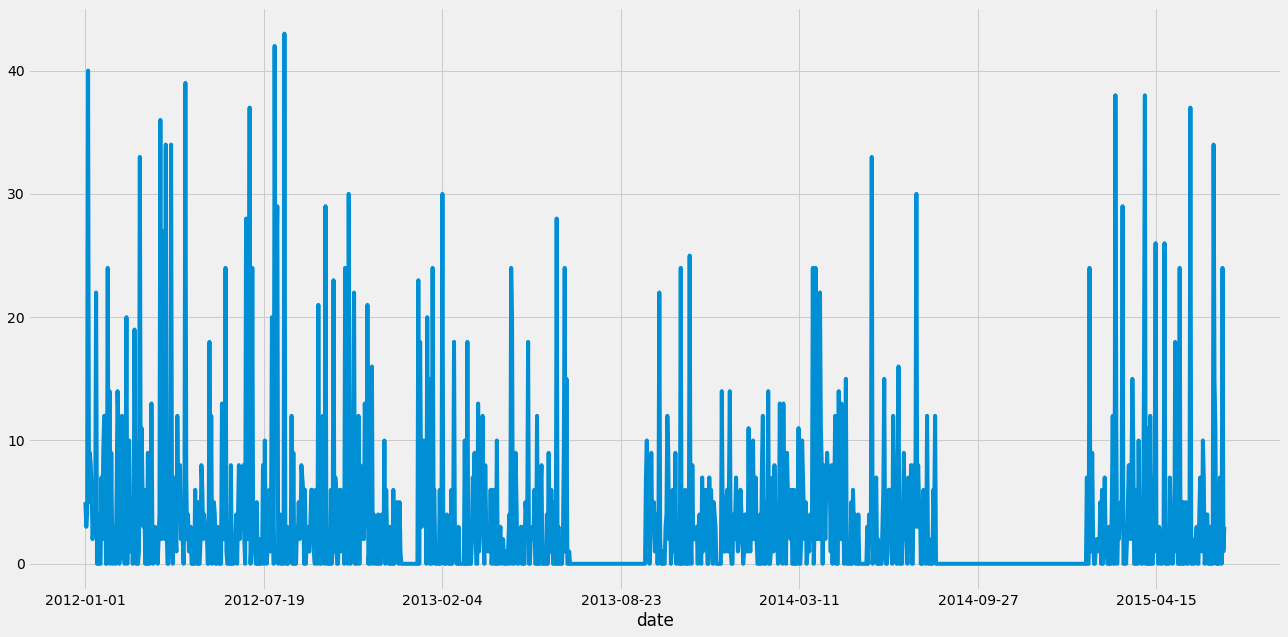

In [9]:
df = xdat.loc[(xdat.item_id == 'HOBBIES_1_288') & (xdat.store_id == 'CA_1') ][['date', 'sales']].copy()

df = df.loc[(df.date >= '2012-01-01') & (df.date <= '2015-06-30')]

df.set_index('date').sales.plot()


Dislacimer: the code for both the basic Croston model and the TSB variant (discussed below) is taken from the excellent post by Nicolas Vandeput:

https://medium.com/towards-data-science/croston-forecast-model-for-intermittent-demand-360287a17f5f

In [10]:
def croston(ts, extra_periods=1, alpha=0.4):
    """

    :param ts:
    :param extra_periods:
    :param alpha:
    :return:
    """
    d = np.array(ts)  # Transform the input into a numpy array
    cols = len(d)  # Historical period length
    d = np.append(d, [np.nan] * extra_periods)  # Append np.nan into the demand array to cover future periods
    
    # level (a), periodicity(p) and forecast (f)
    a, p, f = np.full((3, cols + extra_periods), np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurrence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurrence]
    p[0] = 1 + first_occurrence
    f[0] = a[0] / p[0]
    # Create all the t+1 forecasts
    for t in range(0, cols):
        if d[t] > 0:
            a[t + 1] = alpha*d[t] + (1 - alpha) * a[t]
            p[t + 1] = alpha*q + (1 - alpha) * p[t]
            f[t + 1] = a[t + 1] / p[t + 1]
            q = 1           
        else:
            a[t + 1] = a[t]
            p[t + 1] = p[t]
            f[t + 1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols + 1: cols + extra_periods] = a[cols]
    p[cols + 1: cols + extra_periods] = p[cols]
    f[cols + 1: cols + extra_periods] = f[cols]
    df = pd.DataFrame.from_dict({
        "Demand": d,
        "Forecast": f,
        "Period": p,
        "Level": a,
        "Error": d-f
    })

    return df

Generate a forecast with base Croston method:

In [11]:
pred_croston =  croston(df.sales, extra_periods=10)
pred_croston

,Demand,Forecast,Period,Level,Error
0,5.0,5.000000,1.000000,5.000000,0.000
1,3.0,5.000000,1.000000,5.000000,-2.000
2,4.0,4.200000,1.000000,4.200000,-0.200
3,40.0,4.120000,1.000000,4.120000,35.880
4,5.0,18.472000,1.000000,18.472000,-13.472
...,...,...,...,...,...
1282,NaN,5.050468,1.299267,6.561904,NaN
1283,NaN,5.050468,1.299267,6.561904,NaN
1284,NaN,5.050468,1.299267,6.561904,NaN
1285,NaN,5.050468,1.299267,6.561904,NaN


In [12]:
pred_croston = pred_croston.Forecast.head(len(df))
print('RMSE: ' + str(my_rmse(df.sales, pred_croston)))

RMSE: 6.9581


<AxesSubplot:xlabel='date'>

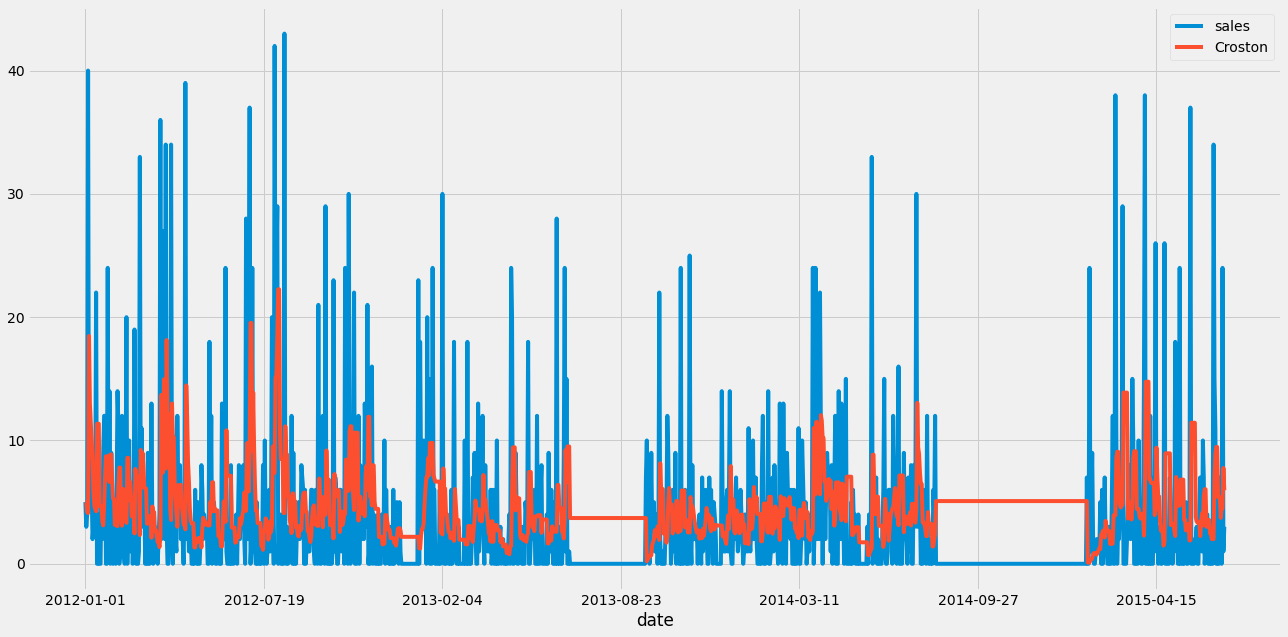

In [13]:
# xvalid = pd.DataFrame(xvalid.values, columns = ['actual'])
df['Croston'] = pred_croston.values
df.set_index('date').plot()

If there is a period with no demand, the forecast from the Croston model is not updated - which is counterintuitive:
- extended period with no demand should lead to a reduced forecast going forward
- surge in demand after a long period of inactivity should lead to an increase

In 2011 Teunter, Synteos and Babai proposed an extension to the basic Croston model: https://www.sciencedirect.com/science/article/abs/pii/S0377221711004437. The main change they proposed was allowing the model to decrease the periodicity estimate, even in the absence of demand. 

The level of demand is estimated in the same manner as before

\begin{equation}
a_{t+1} = \alpha X_t + (1- \alpha) a_t 
\end{equation}

We change the definition of periodicity: $p$ denotes the probability of having a demand occurrence and it will be updated each period:
- decrease if there is no demand occurrence, in an exponential manner 
- increase otherwise

\begin{equation}
p_{t+1} = \beta + (1- \beta) p_t
\end{equation}

if $X_t > 0$ and $(1- \beta) p_t$ otherwise. The forecast for a given period is the given by

\begin{equation}
f_{t+1} = a_{t+1}p_{t+1}
\end{equation}

Caveat emptor:
- the forecast f is defined as the periodicity p multiplied by the level a (**and not divided by it, as in the original model**)
- the forecast for t+1 is defined based on the level and periodicity estimates of t+1 (**and not t**)



In [14]:
def croston_tsb(ts, extra_periods=1, alpha=0.4, beta=0.1):
    """

    :param ts:
    :param extra_periods:
    :param alpha:
    :param beta:
    :return:
    """
    d = np.array(ts)  # Transform the input into a numpy array
    cols = len(d)  # Historical period length
    d = np.append(d, [np.nan] * extra_periods)  # Append np.nan into the demand array to cover future periods

    a, p, f = np.full((3, cols + extra_periods), np.nan)  # level (a), probability(p) and forecast (f)
    first_occurrence = np.argmax(d[:cols] > 0)  # Initialization
    a[0] = d[first_occurrence]
    p[0] = 1 / (1 + first_occurrence)
    f[0] = p[0] * a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0, cols):
        if d[t] > 0:
            a[t + 1] = alpha * d[t] + (1 - alpha) * a[t]
            p[t + 1] = beta * 1 + (1 - beta) * p[t]
        else:
            a[t + 1] = a[t]
            p[t + 1] = (1 - beta) * p[t]
        f[t + 1] = p[t + 1] * a[t + 1]
    # Future Forecast
    a[cols + 1: cols + extra_periods] = a[cols]
    p[cols + 1: cols + extra_periods] = p[cols]
    f[cols + 1: cols + extra_periods] = f[cols]
    df = pd.DataFrame.from_dict({
        "Demand": d,
        "Forecast": f,
        "Period": p,
        "Level": a,
        "Error": d-f
    })

    return df

In [15]:
pred_croston_tsb = croston_tsb(
    df.sales,
    extra_periods=10,
    alpha=0.1,
    beta=0.1
)

pred_croston_tsb = pred_croston_tsb.Forecast.head(len(df))

print('RMSE: ' + str(my_rmse(df.sales,pred_croston_tsb)))

RMSE: 6.1255


<AxesSubplot:xlabel='date'>

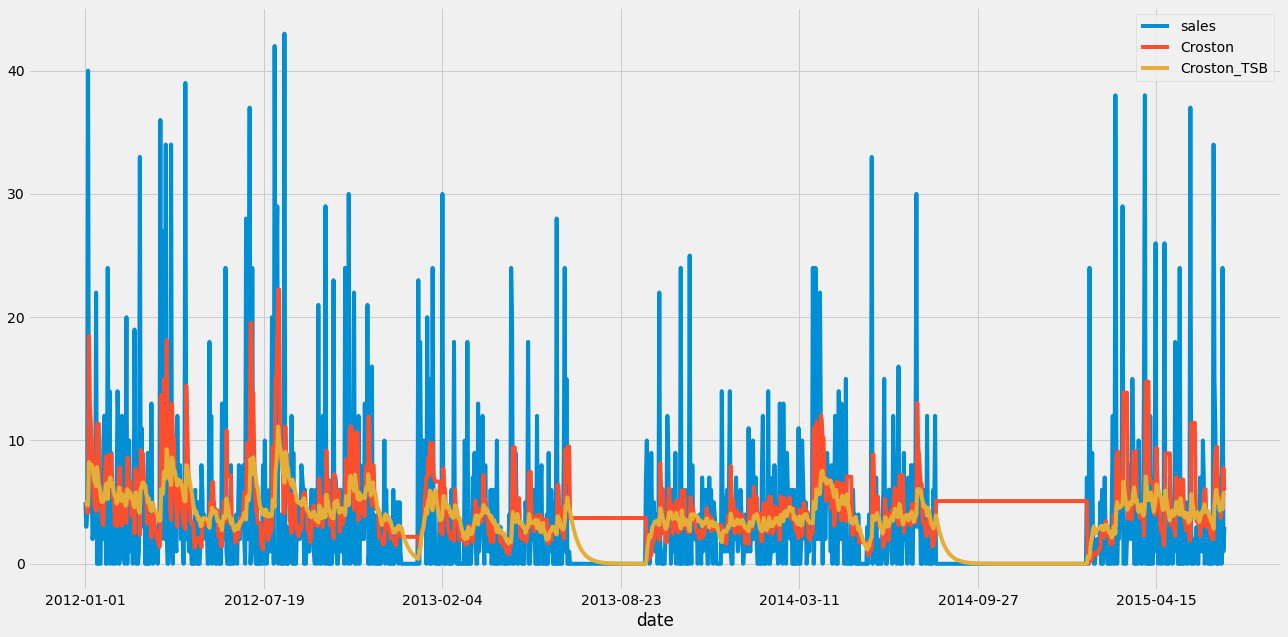

In [16]:
df['Croston_TSB'] = pred_croston_tsb.values
df.set_index('date').plot()

## Takeaway:
Moving from vanilla to TSB Croston:
- improves the error (somewhat)
- solves the issues with forecast adjustment in zero sales periods
- time series as regression
- (lagged) rolling statistics
- distribution of target
- careful about ranges $\rightarrow$ extrapolation

Overall, it gives us a way of handling an intermittent time series, but **it does not have a natural extension to a multivariate case** - so we need to try something else in that instance.